<h1 align="center">Projet Final MDI 721 : Analyse du Vendée Globe 2020 - 2021</h1>
<h3 align="right">Roland SCHWARTZ<br><i>MS IA - 2021/2022</i></h3>

## Initialisation du projet

### Import des librairies

In [1]:
import os
import re
import locale

import requests
from bs4 import BeautifulSoup

import xlwings as xw

from IPython.display import display, Image, HTML, clear_output
import ipywidgets as widgets
from ipyleaflet import Map, Marker, AntPath, basemaps, AwesomeIcon
import seaborn as sns; sns.set_theme()
import matplotlib.colors as mcolors

import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Définition des URL sources et constantes utiles

In [2]:
URL_CLASS = 'https://www.vendeeglobe.org/fr/classement'
URL_GLOSS = 'https://www.vendeeglobe.org/fr/glossaire'

locale.setlocale(locale.LC_ALL, 'fr')

DIR_XL = 'dir_excel'

## Extraction des données du site

### Download des fichiers Excel sur l'intégralité de la course

In [3]:
def get_all_XL(URL_CLASS, DIR_XL):

    if DIR_XL in os.listdir():
        len_dir = len(os.listdir('./'+DIR_XL))
        if len_dir > 0:
            print(f'Le dossier local contient déjà {len_dir} éléments : les fichiers XL ne seront pas téléchargés.\n',
            f'Merci de fournir un nom de dossier vide ou à créer afin de commencer l\'import.')
            return
    else:
        os.mkdir(DIR_XL)
        
    res = requests.get(URL_CLASS)
    soup = BeautifulSoup(res.content, 'html.parser')

    excel_app = xw.App(visible=False)

    options = soup.find("select").find_all("option")
    idx = 0

    for option in options[1:-2]:
        tag_xl = option.attrs['value']+'.xlsx'
        path_xl = DIR_XL+'/'+tag_xl
        url_xl = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+tag_xl
        r_xl = requests.get(url_xl)
        open(path_xl, 'wb').write(r_xl.content)
        excel_book = excel_app.books.open(path_xl)
        excel_book.save()
        excel_book.close()
        idx += 1
        if (idx%100 == 0):
            print(f'Avancement : {idx} / {len(options[1:-2])}')

    excel_app.quit()

    return

In [4]:
get_all_XL(URL_CLASS, DIR_XL)

Le dossier local contient déjà 702 éléments : les fichiers XL ne seront pas téléchargés.
 Merci de fournir un nom de dossier vide ou à créer afin de commencer l'import.


### Récupération et aggrégation des informations sur les IMOCA & skippers

In [5]:
def get_all_carac(URL_GLOSS, rerun=False):
    """
    Retourne df_boat, le dataframe aggrégeant les données récupérées sur URL_GLOSS des skippers et IMOCA
    Si 'df_boat' existe déjà dans les variables globales : pas de recalcul
    Sinon, si 'df_boat.pkl' existe dans le workingdir : load du pickle sans recalcul
    Passer rerun=True pour forcer un recalcul de 'df_boat'
    """

    if ('df_boat' in globals().keys() and not rerun):
        print('\'df_boat\' existe déjà dans les variables.\nPasser rerun à True pour la recalculer')
        return globals()['df_boat']
    elif ('df_boat.pkl' in os.listdir() and not rerun):
        print('Données chargées à partir de \'df_boat_step0.pkl\' du workdir local.\nPasser rerun à True pour la recalculer')
        df_boat = pd.read_pickle('df_boat_step0.pkl')
        return df_boat
    else:   
        res_nav = requests.get(URL_GLOSS)

        soup_nav = BeautifulSoup(res_nav.content, 'html.parser')

        spec_boat_all = soup_nav.find_all(class_="sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6")

        list_spec = []
        max_prog_nav = len(spec_boat_all)
        idx_prog = 0

        w_prog_nav = widgets.IntProgress(
            value=0,
            min=0,
            max=max_prog_nav,
            step=1,
            description='Progress : ',
            bar_style='info',
            orientation='horizontal',
        )

        display(w_prog_nav)

        for spec_boat in spec_boat_all:
            row = {}
            row['Skipper'] = spec_boat.find('span').text
            row['Nom du bateau'] = spec_boat.find('h3').text

            for spec in spec_boat.find_all("li"):
                row[spec.text.split(' : ')[0]] = spec.text.split(' : ')[1]

            url_skipper = 'https://www.vendeeglobe.org'+spec_boat.find(class_='boats-list__popup-skipper-link')['href']

            res_skipper = requests.get(url_skipper)
            soup_skipper = BeautifulSoup(res_skipper.content, 'html.parser')

            row['Nationalité du Skipper'] = soup_skipper.find(class_="skipper-datalist__item m--nationality").find(class_="skipper-datalist__value__text").text
            row['Age du Skipper'] = int(soup_skipper.find(class_="icon icon-calendar").find_parent("p").find(class_="skipper-datalist__value__text").text.split()[0])
            row['Nb. participations du Skipper au Vendée'] = int(soup_skipper.find(class_="skipper-participation__number").find("span").text)
            
            skipper_all_palmares = soup_skipper.find_all(class_='prizes-slider__year')
            cpt_palma = 0
            for year in skipper_all_palmares:
                list_palma_y = year.find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
                cpt_palma += len(list_palma_y) - 1
            
            row['Nb. Palmarès du Skipper'] = cpt_palma

            row['URL Page Skipper'] = url_skipper
            row['URL Photo Skipper'] = 'https://www.vendeeglobe.org'+soup_skipper.find(class_='skipper-hero__figure__img svg-filter').image['xlink:href']
            row['URL Icône bateau'] = 'https://www.vendeeglobe.org'+spec_boat.find('img')['src']

            list_spec.append(row)
            idx_prog += 1
            w_prog_nav.value = idx_prog
            #print(f'Progress : {idx_prog} / {max_prog_nav}')

        df_boat = pd.DataFrame(list_spec)
        df_boat.to_pickle('df_boat.pkl')

        if w_prog_nav.value == max_prog_nav:
            w_prog_nav.bar_style = 'success'
            w_prog_nav.description = 'Done !'

        
        return df_boat


In [6]:
#if ('df_boat' in globals().keys()) : df_boat.to_pickle('df_boat_bckp_temp.pkl'); del(df_boat)
df_boat = get_all_carac(URL_GLOSS, rerun=False)
df_boat.info()

Données chargées à partir de 'df_boat_step0.pkl' du workdir local.
Passer rerun à True pour la recalculer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Skipper                                  33 non-null     object
 1   Nom du bateau                            33 non-null     object
 2   Numéro de voile                          32 non-null     object
 3   Anciens noms du bateau                   24 non-null     object
 4   Architecte                               33 non-null     object
 5   Chantier                                 33 non-null     object
 6   Date de lancement                        33 non-null     object
 7   Longueur                                 33 non-null     object
 8   Largeur                                  33 non-null     object
 9   Tirant d'eau               

## Préparation des données

### Fonctions de conversion des données importées vers des formats plus faciles à manipuler

In [7]:
def str2float(str_XL):
    try:
        floatconv = float(re.search(pattern='[-+]?\d*[\.|,]\d+|\d+', string=str(str_XL).replace(',','.')).group(0))
    except:
        floatconv = None
    return floatconv

def dm2float(str_dm):
    try:
        deg, minutes, direction =  re.split('[°\']', str(str_dm))
        floatconv = (float(deg) + float(minutes)/60) * (-1 if direction in ['W', 'S'] else 1)
    except:
        floatconv = None    
    return floatconv

def natsail2int(str_id):
    try:
        invconv = int(re.search(pattern='\d+', string=str(str_id)).group(0))
    except:
        invconv = 0        
    return invconv

def testfoils(str_df):
    try:
        foils = bool(re.search(pattern='foil', string=str(str_df)).group(0))
    except:
        foils = False
    return foils

def detect_rank(str_XL):
    try:
        tag_rank = re.search(pattern='ARV|RET|NL|Classement', string=str(str_XL)).group(0)
        if (tag_rank == "Classement"):
            tag_rank = pd.to_datetime(str(str_XL), format='%A %d %B %Y à %Hh%M', exact=False, errors='ignore')
    except:
        tag_rank = None
    return tag_rank

### Nettoyage, formatage et aggrégation des données de la course

#### Nomenclature des colonnes et dictionnaires de conversion

In [8]:
col_names = ['Rang', 'Numéro Voile', 'Latitude', 'Longitude', 
			'Cap sur 30 min (°)', 'Vitesse sur 30 min (kts)',
			'VMG sur 30 min (kts)', 'Distance sur 30 min (nm)', 
			'Cap depuis dernier classement (°)', 'Vitesse depuis dernier classement (kts)',
			'VMG depuis dernier classement (kts)', 'Distance depuis dernier classement (nm)',
			'Cap sur 24h (°)', 'Vitesse sur 24h (kts)', 'VMG sur 24h (kts)', 'Distance sur 24h (nm)',
			'Distance restante (nm)', 'Distance au premier (nm)']

dico_conv = dict.fromkeys(col_names[4:], str2float)
dico_conv.update(dict.fromkeys(['Latitude', 'Longitude'], dm2float))
dico_conv['Numéro Voile'] = natsail2int

#### Test des lignes à parser dans Excel

In [9]:
def detect_rows(xl_file):
    """
    Lis la colonne B de xl_file dans DIR_XL et retourne :
        - date_idx : date et heure du classement (format Timestamp)
        - skip_rows : à affecter à skiprows par la suite pour effectuer un parsing complet de xl_file
        - skip_foot : à affecter à skipfooter par la suite pour effectuer un parsing complet de xl_file
    """

    xl_file_path = './'+DIR_XL+'/'+xl_file
    df_detect_ranks = pd.read_excel(xl_file_path, header=None, names=['Rang'], usecols='B', converters={'Rang' : detect_rank})

    if 'ARV' in df_detect_ranks['Rang'].value_counts():
        nb_arv = df_detect_ranks['Rang'].value_counts()['ARV']
    else:
        nb_arv = 0

    if 'NL' in df_detect_ranks['Rang'].value_counts():
        nb_ret = df_detect_ranks['Rang'].value_counts()['NL']
    else:
        nb_ret = 0

    if 'RET' in df_detect_ranks['Rang'].value_counts():
        nb_ret += df_detect_ranks['Rang'].value_counts()['RET']

    date_idx = df_detect_ranks.iloc[2].values[0]
    skip_rows = (nb_arv + 2)*(nb_arv != 0) + 5 # si il y a des arrivants, on saute 2 lignes en plus des 5 "classiques"
    skip_foot = nb_ret + 4

    return date_idx, skip_rows, skip_foot


#### Récupération et mise en forme des données de chaque participant encore en course à un unique Timestamp

In [10]:
def parse_runners(xl_file, dico_conv, col_names):
    """
    Récupère et prépare les données de xl_file dans DIR_XL pour les participants encore en course (ni abandonné ni déjà arrivé).
    Retourne un df MultiIndexé ['Numéro de Voile', 'Date'] (cette dernière étant identique pour tous) en vue d'être aggrégé au
    DataFrame contenant l'intégralité des données de course.
    """

    xl_file_path = './'+DIR_XL+'/'+xl_file
    date_idx, skip_rows, skip_foot = detect_rows(xl_file)
    df_course_solo = pd.read_excel(xl_file_path, converters=dico_conv, na_values=['','\n','\\n'],
                usecols='B,C,F:U', skiprows=skip_rows, skipfooter=skip_foot, header=None, names=col_names, dtype={'Rang':int})
    mi = pd.MultiIndex.from_product([df_course_solo['Numéro Voile'],[date_idx]], names=['Numéro Voile', 'Date'])
    df_course_solo.set_index(mi, inplace=True)
    df_course_solo.pop('Numéro Voile')
    df_course_solo.sort_index(inplace=True)

    return df_course_solo

#### Aggrégation des données de course de chaque fichier Excel dans un unique DataFrame Multi Indexé

In [11]:
def create_df_course(dico_conv, col_names, rerun=False):
    """
    Retourne df_course, le dataframe multi-indexé par n° de voile / dates sur toutes les mesures 'type course'
    Si 'df_course' existe déjà dans les variables globales : pas de recalcul
    Sinon, si 'df_course.pkl' existe dans le workingdir : load du pickle sans recalcul
    Passer rerun=True pour forcer un recalcul de 'df_course'
    """

    if ('df_course' in globals().keys() and not rerun):
        print('\'df_course\' existe déjà dans les variables.\nPasser rerun à True pour la recalculer')
        return globals()['df_course']
    elif ('df_course.pkl' in os.listdir() and not rerun):
        print('Données chargées à partir de \'df_course.pkl\' du workdir local.\nPasser rerun à True pour la recalculer')
        df_course = pd.read_pickle('df_course.pkl')
        return df_course
    else:
        print('Calcul de df_course commencé')
        list_all_df = [ parse_runners(f,dico_conv,col_names) for f in os.listdir('./'+DIR_XL) ]
        df_course = pd.concat(list_all_df, names=['Numéro Voile', 'Date'])
        df_course.sort_index(inplace=True)
        df_course.to_pickle('df_course.pkl')
        print(f'df_course créée et sauvegardée en local')
        return df_course

In [12]:
df_course = create_df_course(dico_conv,col_names, rerun=False)
df_course.info()

Données chargées à partir de 'df_course.pkl' du workdir local.
Passer rerun à True pour la recalculer
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15272 entries, (1, Timestamp('2020-11-08 16:00:00')) to (222, Timestamp('2021-03-05 05:00:00'))
Data columns (total 17 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Rang                                     15272 non-null  int32  
 1   Latitude                                 15272 non-null  float64
 2   Longitude                                15272 non-null  float64
 3   Cap sur 30 min (°)                       15272 non-null  float64
 4   Vitesse sur 30 min (kts)                 15272 non-null  float64
 5   VMG sur 30 min (kts)                     15272 non-null  float64
 6   Distance sur 30 min (nm)                 15272 non-null  float64
 7   Cap depuis dernier classement (°)        15272 non-null  float64
 8   Vitesse depuis

#### Rapide "sanity check" via le rang

In [13]:
nb_skippers = df_course.index.unique(level=0).nunique()

verif_dfs_via_ranks = (df_course['Rang'].nunique() == len(df_boat) == nb_skippers)
print(f'Q : Nombre de valeurs uniques de classements = nombre de participants = nombre de N° de voiles ?\n'
      f'A : {verif_dfs_via_ranks}')


Q : Nombre de valeurs uniques de classements = nombre de participants = nombre de N° de voiles ?
A : True


### Nettoyage, formatage et aggrégation des données Skipper & classement final

#### Mise en forme des données Skipper

In [14]:
list_col_float_boat = ['Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)', 'Hauteur mât',
                        'Surface de voiles au près', 'Surface de voiles au portant']

df_boat['Date de lancement'] = pd.to_datetime(df_boat['Date de lancement'], format='%d %B %Y', exact=True, errors='ignore')

if 'Présence de foils' not in df_boat.columns:
    df_boat['Présence de foils'] = df_boat['Nombre de dérives'].apply(testfoils)

df_boat[list_col_float_boat] = df_boat[list_col_float_boat].applymap(str2float)
df_boat[['Numéro de voile', 'Nombre de dérives']] = df_boat[['Numéro de voile', 'Nombre de dérives']].applymap(natsail2int)

df_boat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Skipper                                  33 non-null     object        
 1   Nom du bateau                            33 non-null     object        
 2   Numéro de voile                          33 non-null     int64         
 3   Anciens noms du bateau                   24 non-null     object        
 4   Architecte                               33 non-null     object        
 5   Chantier                                 33 non-null     object        
 6   Date de lancement                        33 non-null     datetime64[ns]
 7   Longueur                                 33 non-null     float64       
 8   Largeur                                  33 non-null     float64       
 9   Tirant d'eau                             33 n

#### Récupération des données du classement final

In [15]:
def arrivaldate(str_XL):
    try:
        dateconv = pd.to_datetime(str(str_XL).strip('FR'), dayfirst=True)
        return dateconv
    except:
        return None

def timegap(str_XL):
    try:
        gapconv = pd.Timedelta(str(str_XL).replace('j','d').split('\n')[0])
        return gapconv
    except:
        return None

def arrivalrank(str_XL):
    if (str(str_XL) == 'RET' or str(str_XL) == None):
        return None
    else:
        rank = int(str(str_XL).split('\n')[0])
        return rank

def nameskippers(str_XL):
    return str(str_XL).split('\n')[0]

In [16]:
xl_arrival = './'+DIR_XL+'/20210305_080000.xlsx'
arrival_names = ['Classement', 'Numéro de voile', 'Skipper', 'Date arrivée', 'Temps de course', 
                'Ecart au premier', 'Ecart au précédent', 'Vitesse moyenne / fond (kts)',
                'Distance parcourue (nm)']

usecols_arrival = 'B:D,H,I,N,P,T,U'

dico_arrival = dict.fromkeys([8, 13, 15], timegap)
dico_arrival.update(dict.fromkeys([19, 20], str2float))
dico_arrival[1] = arrivalrank
dico_arrival[2] = natsail2int
dico_arrival[3] = nameskippers
dico_arrival[7] = arrivaldate

df_arrival = pd.read_excel(xl_arrival, na_values=['','\n','\\n'], converters=dico_arrival,
                     usecols=usecols_arrival, header=None, skiprows=5, skipfooter=4)

df_arrival.rename(columns=dict(zip(df_arrival.columns, arrival_names)), inplace=True)

df_arrival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   Classement                    25 non-null     float64        
 1   Numéro de voile               33 non-null     int64          
 2   Skipper                       33 non-null     object         
 3   Date arrivée                  25 non-null     datetime64[ns] 
 4   Temps de course               25 non-null     timedelta64[ns]
 5   Ecart au premier              24 non-null     timedelta64[ns]
 6   Ecart au précédent            24 non-null     timedelta64[ns]
 7   Vitesse moyenne / fond (kts)  25 non-null     float64        
 8   Distance parcourue (nm)       25 non-null     float64        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1), timedelta64[ns](3)
memory usage: 2.4+ KB


In [17]:
df_arrival.head()

,Classement,Numéro de voile,Skipper,Date arrivée,Temps de course,Ecart au premier,Ecart au précédent,Vitesse moyenne / fond (kts),Distance parcourue (nm)
0,1.0,17,Yannick Bestaven,2021-01-28 04:19:46,80 days 03:44:46,NaT,NaT,14.8,28583.8
1,2.0,79,Charlie Dalin,2021-01-27 20:35:47,80 days 06:15:47,0 days 02:31:01,0 days 02:31:01,15.1,29135.0
2,3.0,18,Louis Burton,2021-01-28 00:45:12,80 days 10:25:12,0 days 06:40:26,0 days 04:09:25,14.8,28650.0
3,4.0,1,Jean Le Cam,2021-01-28 20:19:55,80 days 13:44:55,0 days 10:00:09,0 days 03:19:43,14.1,27501.5
4,5.0,10,Boris Herrmann,2021-01-28 11:19:45,80 days 14:59:45,0 days 11:14:59,0 days 01:14:50,14.7,28448.5


#### Merge des données d'arrivée avec celles des Skippers/IMOCA

##### Correction des différences entre les données du site et celles des tableaux Excel
On prend pour référence les tableaux Excel plutôt que les informations scrappées des pages internet, plus disparates et moins formattées dans l'ensemble.

In [18]:
df_boat[['Numéro de voile', 'Skipper']][~df_boat['Numéro de voile'].isin(df_arrival['Numéro de voile'])].sort_values('Skipper')

,Numéro de voile,Skipper
17,16,Boris HERRMANN
16,77,Pip HARE
25,0,Thomas RUYANT


In [19]:
df_arrival[['Numéro de voile', 'Skipper']][~df_arrival['Numéro de voile'].isin(df_boat['Numéro de voile'])].sort_values('Skipper')

,Numéro de voile,Skipper
4,10,Boris Herrmann
18,777,Pip Hare
5,59,Thomas Ruyant


In [20]:
diff_arriv_idx = df_arrival[['Numéro de voile', 'Skipper']][~df_arrival['Numéro de voile'].isin(df_boat['Numéro de voile'])].sort_values('Skipper').index
diff_boat_idx = df_boat[['Numéro de voile', 'Skipper']][~df_boat['Numéro de voile'].isin(df_arrival['Numéro de voile'])].sort_values('Skipper').index
df_boat.loc[diff_boat_idx, 'Numéro de voile'] = df_arrival.loc[diff_arriv_idx, 'Numéro de voile'].values

In [21]:
df_boat['Numéro de voile'].isin(df_arrival['Numéro de voile']).value_counts()

True    33
Name: Numéro de voile, dtype: int64

Les disparités entre les numéros de voile des tableaux Excel et du site étant réglés, on peut réindexer sur ceux-ci et fusionner les données.

In [22]:
df_boat.set_index('Numéro de voile', inplace=True)
df_arrival.set_index('Numéro de voile', inplace=True)

Une dernière petite disparité à vérifier du côté des noms de Skippers :

In [23]:
df_arrival['Skipper'].str.casefold().isin(df_boat['Skipper'].str.casefold()).value_counts()

True     30
False     3
Name: Skipper, dtype: int64

In [24]:
df_arrival['Skipper'][~df_arrival['Skipper'].str.casefold().isin(df_boat['Skipper'].str.casefold())]

Numéro de voile
14     Arnaud Boissieres
7             Alan Roura
109      Samantha Davies
Name: Skipper, dtype: object

In [25]:
df_boat['Skipper'][~df_boat['Skipper'].str.casefold().isin(df_arrival['Skipper'].str.casefold())]

Numéro de voile
14     Arnaud BOISSIÈRES
109           Sam DAVIES
7            Alan  ROURA
Name: Skipper, dtype: object

Rien d'affolant, on pourra récupérer la colonne des noms de df_arrival lors de la fusion.

In [26]:
df_boat_merged = df_arrival.join(df_boat.drop(columns='Skipper'), how='outer')
display(df_boat_merged.info())
df_boat_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 1 to 1000
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype          
---  ------                                   --------------  -----          
 0   Classement                               25 non-null     float64        
 1   Skipper                                  33 non-null     object         
 2   Date arrivée                             25 non-null     datetime64[ns] 
 3   Temps de course                          25 non-null     timedelta64[ns]
 4   Ecart au premier                         24 non-null     timedelta64[ns]
 5   Ecart au précédent                       24 non-null     timedelta64[ns]
 6   Vitesse moyenne / fond (kts)             25 non-null     float64        
 7   Distance parcourue (nm)                  25 non-null     float64        
 8   Nom du bateau                            33 non-null     object         
 9   Anciens noms du bateau          

None

,Classement,Skipper,Date arrivée,Temps de course,Ecart au premier,Ecart au précédent,Vitesse moyenne / fond (kts),Distance parcourue (nm),Nom du bateau,Anciens noms du bateau,...,Surface de voiles au près,Surface de voiles au portant,Nationalité du Skipper,Age du Skipper,Nb. participations du Skipper au Vendée,Nb. Palmarès du Skipper,URL Page Skipper,URL Photo Skipper,URL Icône bateau,Présence de foils
Numéro de voile,,,,,,,,,,,,,,,,,,,,,
1,4.0,Jean Le Cam,2021-01-28 20:19:55,80 days 13:44:55,0 days 10:00:09,0 days 03:19:43,14.1,27501.5,Yes We Cam!,"Cheminées Poujoulat, Mare, Maître CoQ, Mapfre,...",...,300.0,620.0,FR,62,5,22,https://www.vendeeglobe.org/fr/skippers/116/je...,https://www.vendeeglobe.org/medias/05/04/50456...,https://www.vendeeglobe.org/medias/05/09/50965...,False
2,11.0,Armel Tripon,2021-02-01 07:27:50,84 days 19:07:50,4 days 15:23:04,2 days 04:37:35,13.9,28315.2,L'OCCITANE EN PROVENCE,NaN,...,270.0,535.0,FR,46,1,0,https://www.vendeeglobe.org/fr/skippers/101/ar...,https://www.vendeeglobe.org/medias/05/05/50571...,https://www.vendeeglobe.org/medias/05/04/50494...,True
4,NaN,Sébastien Simon,NaT,NaT,NaT,NaT,NaN,NaN,ARKEA PAPREC,NaN,...,260.0,600.0,FR,31,1,47,https://www.vendeeglobe.org/fr/skippers/90/seb...,https://www.vendeeglobe.org/medias/05/08/50817...,https://www.vendeeglobe.org/medias/05/08/50818...,True
6,NaN,Nicolas Troussel,NaT,NaT,NaT,NaT,NaN,NaN,CORUM L'EPARGNE,NaN,...,270.0,535.0,FR,47,1,12,https://www.vendeeglobe.org/fr/skippers/108/ni...,https://www.vendeeglobe.org/medias/05/03/50384...,https://www.vendeeglobe.org/medias/05/04/50487...,True
7,17.0,Alan Roura,2021-02-11 20:29:56,95 days 06:09:56,15 days 02:25:10,0 days 08:37:00,12.5,28603.3,LA FABRIQUE,"Brit Air, Votre Nom autour du Monde, MACSF",...,290.0,580.0,CH,28,2,15,https://www.vendeeglobe.org/fr/skippers/99/ala...,https://www.vendeeglobe.org/medias/05/08/50816...,https://www.vendeeglobe.org/medias/05/08/50814...,True


On classe les données par ordre d'arrivée (NaN par défaut en dernier) et on peut facilement accéder et afficher un subset des données des premiers arrivés, par exemple, à notre convenance.

In [27]:
df_boat_merged.sort_values('Classement', inplace=True)
df_boat_merged[df_arrival.columns[0:2].to_list()+['Nationalité du Skipper', 'Nom du bateau']+df_arrival.columns[3:].to_list()].head(10)

,Classement,Skipper,Nationalité du Skipper,Nom du bateau,Temps de course,Ecart au premier,Ecart au précédent,Vitesse moyenne / fond (kts),Distance parcourue (nm)
Numéro de voile,,,,,,,,,
17,1.0,Yannick Bestaven,FR,Maître CoQ IV,80 days 03:44:46,NaT,NaT,14.8,28583.8
79,2.0,Charlie Dalin,FR,APIVIA,80 days 06:15:47,0 days 02:31:01,0 days 02:31:01,15.1,29135.0
18,3.0,Louis Burton,FR,BUREAU VALLEE 2,80 days 10:25:12,0 days 06:40:26,0 days 04:09:25,14.8,28650.0
1,4.0,Jean Le Cam,FR,Yes We Cam!,80 days 13:44:55,0 days 10:00:09,0 days 03:19:43,14.1,27501.5
10,5.0,Boris Herrmann,DE,SEAEXPLORER - YACHT CLUB DE MONACO,80 days 14:59:45,0 days 11:14:59,0 days 01:14:50,14.7,28448.5
59,6.0,Thomas Ruyant,FR,LinkedOut,80 days 15:22:01,0 days 11:37:15,0 days 00:22:16,15.1,29175.5
1000,7.0,Damien Seguin,FR,GROUPE APICIL,80 days 21:58:20,0 days 18:13:34,0 days 06:36:19,14.2,27512.3
34,8.0,Giancarlo Pedote,IT,PRYSMIAN GROUP,80 days 22:42:20,0 days 18:57:34,0 days 00:44:00,14.7,28489.9
9,9.0,Benjamin Dutreux,FR,OMIA - WATER FAMILY,81 days 19:45:20,1 days 16:00:34,0 days 21:03:00,14.2,27832.5


#### Création des couleurs associées aux skippers

In [28]:
# palette sns de 33 couleurs différentes, en sombre et clair
palt_dark_colors = sns.hls_palette(nb_skippers, h=0, s=1, l=.2)
palt_light_colors = sns.hls_palette(nb_skippers, h=0, s=1, l=.75)

# même palettes sous forme de liste de valeurs RGB en hexa (HTML friendly)
list_hexa_darks = list(map(mcolors.to_hex, palt_dark_colors))
list_hexa_lights = list(map(mcolors.to_hex, palt_light_colors))

sns.set_palette(palt_light_colors)

In [29]:
df_boat_merged.loc[df_boat_merged.index.sort_values(), 'hex_dark_clrs'] = list_hexa_darks
df_boat_merged.loc[df_boat_merged.index.sort_values(), 'hex_light_clrs'] = list_hexa_lights

Les deux dataframes ayant été consolidées, une sauvegarde "just in case" ne fait jamais de mal ... (et il est toujours pratique de pouvoir recharger les données en mémoire plus rapidement et sans le besoin d'une connexion internet !)

In [30]:
df_course.to_pickle('df_course_vFinal.pkl')
df_boat_merged.to_pickle('df_boat_merged_vFinal.pkl')

## Visualisation des données

#### Evolution des rangs de tous les skippers pendant la course

On remplace les "NaN" des abandons par un 0 pour plus de lisibilité sur le graphe (correspond à une chute brutale du classement à zéro pour les skippers identifiés 'RET' dans les tableaux de course, entrainant donc logiquement un décalage synchronisé des skippers suivants).

In [31]:
# Dictionnaire {Numéro de voile : Classement à l'arrive}, les NaN (= abandon) sont remplacés par zéro
dict_fill_clssmt = dict(zip(df_boat_merged.index.sort_values().tolist(),df_boat_merged.sort_values('Numéro de voile')['Classement'].fillna(0).tolist()))

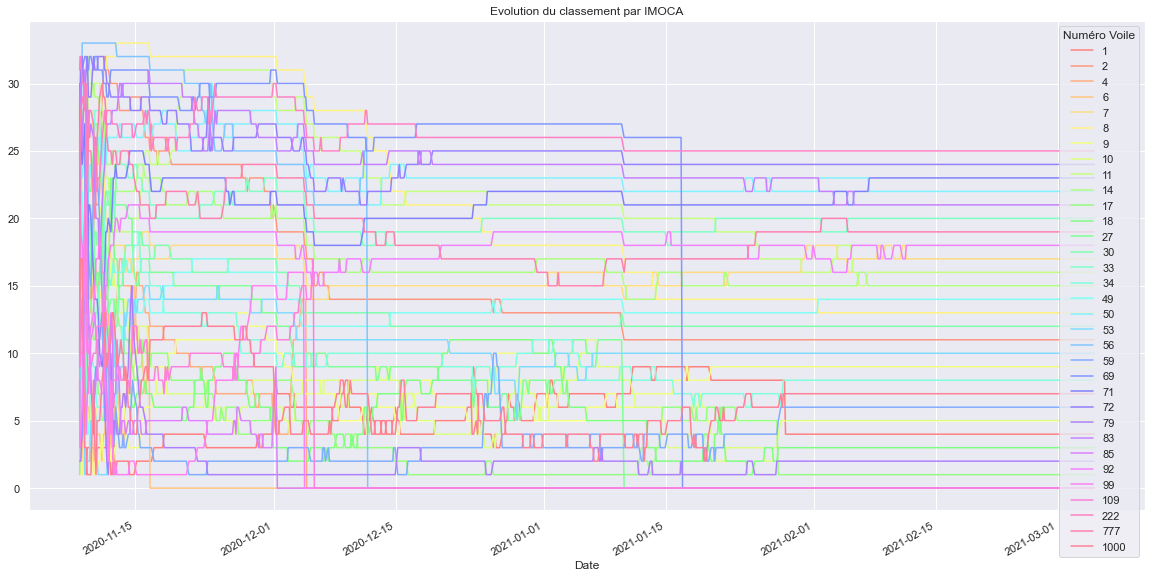

In [32]:
df_ranks = df_course['Rang'].groupby(level=['Date'])
df_ranks = df_course['Rang'].unstack(0)
df_ranks.fillna(dict_fill_clssmt).plot(figsize=(20,10), grid=None, title='Evolution du classement par IMOCA');

### Widget de visualisation synthétique des duos Skipper / IMOCA

#### Définition des layouts

In [33]:
fit_opt = 'contain'
image_margin = '0 0 0 0'

dark_clr = df_boat_merged.iat[0,30]
light_clr = df_boat_merged.iat[0,31]

tplt_lay={'height':'auto', 'width':'auto', 'justify_self':'center', 'align_self':'flex-end'}

gridlayout = widgets.Layout(
    width='100%',
    height='auto',
    border="".join(['4px solid ',dark_clr]),
    grid_template_columns='4fr 2fr 1fr 3fr 4fr',
    grid_template_rows='1fr 4fr 75%',
    grid_template_areas='''
    "wSkip wList wRank wNomBoat wBoat"
    "wSkip wImgSkip wImgSkip wImgBoat wBoat "
    "wMap wMap wMap wMap wMap"
    '''
    )

#img_layout = widgets.Layout()
#img_layout.object_fit = fit_opt
#img_layout.margin = image_margin
#img_layout.width = 'auto'


#### Fonction de contrôle du Widget

In [34]:
def handle_skipper_chg(change):
    df_skipper = df_boat_merged[df_boat_merged['Skipper'] == change.new]

    dark_clr = df_skipper['hex_dark_clrs'].values[0]
    light_clr = df_skipper['hex_light_clrs'].values[0]
    
    new_url_skip = df_skipper['URL Photo Skipper'].values[0]
    skipper_img_widg.value = Image(new_url_skip).data
    skipper_img_widg.layout.border="".join(['2px solid ',light_clr])
    
    new_url_boat = df_skipper['URL Icône bateau'].values[0]
    boat_img_widg.value = Image(new_url_boat).data
    
    new_html_boat = "".join(['<h2 align="center"><font color="',dark_clr,'"><i><u>',df_skipper['Nom du bateau'].values[0],'</i></u></h2>'])
    title_boat.value = new_html_boat

    test_rank = df_skipper['Classement'].values[0]
    try:
        rank_skip = int(test_rank)
    except:
        rank_skip = 'ABD'

    html_rank = "".join(['<p align="center"><b>Rang :</b></p><h1 align="center"><font color="',dark_clr,'">',str(rank_skip),'</h1>'])
    widg_rank.value = html_rank

    out.clear_output()
    out2.clear_output()

    with out : display(df_skipper[df_skipper.columns[np.r_[22:26,2:8]]].transpose())
    with out2 : display(df_skipper[df_skipper.columns[np.r_[10:22,29]]].transpose())

    out.layout.border="".join(['2px solid ',light_clr])
    out2.layout.border="".join(['2px solid ',light_clr])

    grid_widg.layout.border="".join(['4px solid ',dark_clr])

    locations = df_course.loc[[df_skipper.index[0]],['Latitude','Longitude']].droplevel(['Numéro Voile']).dropna().values

    for layer in map_ant.layers[1:]:
            map_ant.remove_layer(layer)

    if (locations[:,1].argmin() == locations[:,1].argmax()+1):
        newloc = [locations[:locations[:,1].argmin()], locations[locations[:,1].argmin():]]
    else:
        newloc = [locations]

    for loc in newloc:

        ant_path = AntPath(
            locations=loc.tolist(),
            dash_array=[1, 20],
            delay=200,
            color=dark_clr,
            pulse_color=light_clr,
            weight=3
        )
        map_ant.add_layer(ant_path)

    start_mrkr.location=locations[0].tolist()

    if rank_skip == 'ABD':

        end_icn = AwesomeIcon(
            name='fa-bolt',
            marker_color='red',
            icon_color='black',
            spin=False
        )

        end_mrkr = Marker(icon=end_icn, location=(locations[-1].tolist()), title='Dernière géo-localisation du skipper', draggable=False)
    else:
        end_icn = AwesomeIcon(
            name='fa-flag-o',
            marker_color='blue',
            icon_color='white',
            spin=False
        )

        end_mrkr = Marker(icon=end_icn, location=(locations[-1].tolist()), title='Arrivée de la course', draggable=False)

    map_ant.add_layer(start_mrkr)
    map_ant.add_layer(end_mrkr)
        




#### Initialisation et visualisation du Widget
Utiliser le menu déroulant pour voir les données concernant chaque skipper (nécessite un kernel actif)

In [35]:
list_skipper = df_boat_merged['Skipper'].tolist()

skipper_select = widgets.Dropdown(options=list_skipper, value=list_skipper[0], layout=tplt_lay)
skipper_select.layout.grid_area='wList'
#skipper_select.layout.width='175px'
#skipper_select.layout.align_self = 'flex-end'

skipper_select.observe(handle_skipper_chg, names='value')

df_view_skipper = df_boat_merged[df_boat_merged['Skipper'] == skipper_select.value]
dark_clr = df_view_skipper['hex_dark_clrs'].values[0]
light_clr = df_view_skipper['hex_light_clrs'].values[0]

html_boat = "".join(['<h2 align="center"><font color="',dark_clr,'"><i><u>',df_boat_merged['Nom du bateau'][df_boat_merged['Skipper'] == skipper_select.value].values[0],'</i></u></h2>'])
title_boat = widgets.HTML(value=html_boat, layout=tplt_lay)
title_boat.layout.grid_area='wNomBoat'

test_rank = df_boat_merged[df_boat_merged['Skipper'] == skipper_select.value]['Classement']
try:
    rank_skip = int(test_rank)
except:
    rank_skip = 'ABD'

html_rank = "".join(['<p align="center"><b>Rang :</b></p><h1 align="center"><font color="',dark_clr,'">',str(rank_skip),'</h1>'])

widg_rank = widgets.HTML(value=html_rank, layout=tplt_lay)
widg_rank.layout.grid_area='wRank'

data_img = Image(df_boat_merged['URL Photo Skipper'][df_boat_merged['Skipper'] == skipper_select.value].values[0]).data
skipper_img_widg = widgets.Image(value=data_img, format='jpg', layout=tplt_lay)
skipper_img_widg.layout.grid_area = 'wImgSkip'
skipper_img_widg.layout.border="".join(['2px solid ',light_clr])
#skipper_img_widg.layout.align_self = 'flex-end'

data_boat_img = Image(df_boat_merged['URL Icône bateau'][df_boat_merged['Skipper'] == skipper_select.value].values[0]).data
boat_img_widg = widgets.Image(value=data_boat_img, format='jpg', layout=tplt_lay)
boat_img_widg.layout.grid_area = 'wImgBoat'
boat_img_widg.layout.width = '100%'

out = widgets.Output(layout=tplt_lay)
out.layout.grid_area='wSkip'
out.layout.border="".join(['2px solid ',light_clr])
#out.layout.align_self = 'flex-end'

out2 = widgets.Output(layout=tplt_lay)
out2.layout.grid_area='wBoat'
out2.layout.border="".join(['2px solid ',light_clr])
#out2.layout.align_self = 'flex-end'

with out : display(df_view_skipper[df_view_skipper.columns[np.r_[22:26,2:8]]].transpose())
with out2 : display(df_view_skipper[df_view_skipper.columns[np.r_[10:22,29]]].transpose())

map_ant = Map(basemap=basemaps.Esri.NatGeoWorldMap, zoom=3, dragging=True, world_copy_jump=True)
map_ant.layout.grid_area = 'wMap'
map_ant.layout.height = '600px'
#map_ant.layout.self_align = 'stretch'

locations = df_course.loc[[df_view_skipper.index[0]],['Latitude','Longitude']].droplevel(['Numéro Voile']).dropna().values

"""for layer in map_ant.layers[1:]:
        map_ant.remove_layer(layer)
"""
if (locations[:,1].argmin() == locations[:,1].argmax()+1):
    newloc = [locations[:locations[:,1].argmin()], locations[locations[:,1].argmin():]]
else:
    newloc = [locations]

for loc in newloc:

    ant_path = AntPath(
        locations=loc.tolist(),
        dash_array=[1, 20],
        delay=200,
        color=dark_clr,
        pulse_color=light_clr,
        weight=3
    )
    map_ant.add_layer(ant_path)

start_icn = AwesomeIcon(
    name='fa-flag-checkered',
    marker_color='green',
    icon_color='black',
    spin=False
)

start_mrkr = Marker(icon=start_icn, location=(locations[0].tolist()), title='Départ de la course', draggable=False)

if rank_skip == 'ABD':

    end_icn = AwesomeIcon(
        name='fa-bolt',
        marker_color='red',
        icon_color='black',
        spin=False
    )

    end_mrkr = Marker(icon=end_icn, location=(locations[-1].tolist()), title='Dernière géo-localisation du skipper', draggable=False)
else:
    end_icn = AwesomeIcon(
        name='fa-flag-o',
        marker_color='blue',
        icon_color='white',
        spin=False
    )

    end_mrkr = Marker(icon=end_icn, location=(locations[-1].tolist()), title='Arrivée de la course', draggable=False)

map_ant.add_layer(start_mrkr)
map_ant.add_layer(end_mrkr)

child_grid = [out, skipper_select, title_boat, widg_rank, skipper_img_widg, boat_img_widg, out2, map_ant]
grid_widg = widgets.GridBox(child_grid, layout=gridlayout)

grid_widg

GridBox(children=(Output(layout=Layout(align_self='flex-end', border='2px solid #97ff80', grid_area='wSkip', h…

## Analyse des données de la course

In [36]:
sns.set_theme()

### Impact des foils sur la performance

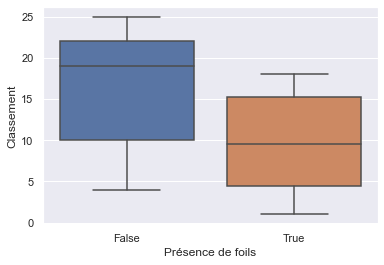

In [73]:
sns.boxplot(data=df_boat_merged, x="Présence de foils", y="Classement");

On peut remarquer une assez nette différence sur les moyennes de classement (plus c'est bas : mieux c'est !) entre les bateaux équipés de foils et ceux qui n'en ont pas. Il n'empêche que si ceux qui n'en ont pas sont plus présents en fin de classement, il est pertinent de remarquer que les meilleures valeurs sont proches de celles des bateaux avec foil : la technologie ne fait pas tout !

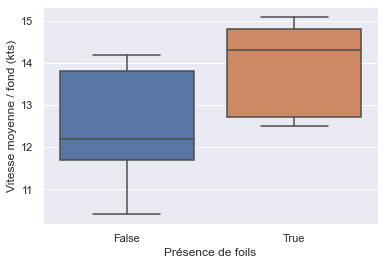

In [75]:
sns.boxplot(data=df_boat_merged, x="Présence de foils", y="Vitesse moyenne / fond (kts)");

Une piste d'explication de la différence de classement pourrait se trouver, sans trop de surprise, dans la vitesse moyenne calculée pour chaque embarcation : il y a tout de même une différence de plus de 2 noeuds ... les meilleures vitesses moyennes des bateaux non équipées de foils n'arrivent même pas à la moyenne de ceux qui en ont !

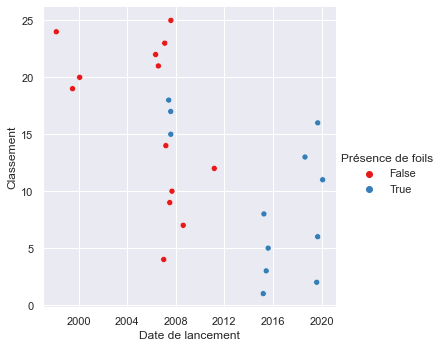

In [80]:
sns.relplot(x="Date de lancement", y="Classement", hue="Présence de foils", data=df_boat_merged,
           markers=["o", "x"], palette="Set1");

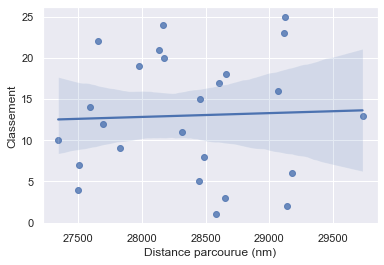

In [55]:
sns.regplot(x="Distance parcourue (nm)", y="Classement", data=df_boat_merged);

La distance parcourue (avec un delta total de plus de 2500 miles nautiques, soit tout de même plus de 4600 kilomètres !) semble avoir très peu d'influence le classement final, fait assez surprenant, même : la corrélation (certes, de mauvaise qualité) semble indiquer que parcourir plus de distance ... permettrait d'être un peu mieux classé ! Il faudra sûrement y voir la capacité des meilleurs navigateurs à opérer les bons trade-off en n'hésitant pas à dévier du cap idéal en échange d'un gain de vitesse.

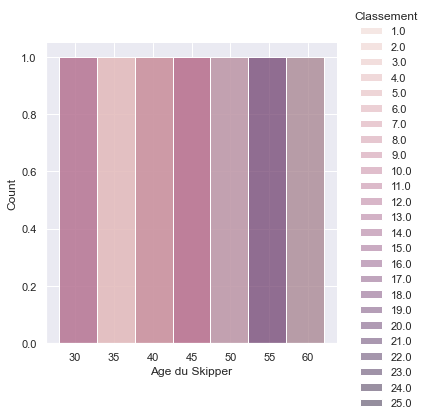

In [82]:
sns.displot(df_boat_merged, x="Age du Skipper", hue="Classement")

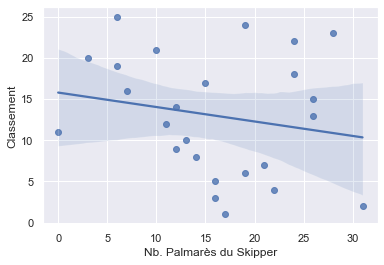

In [56]:
sns.regplot(x="Nb. Palmarès du Skipper", y="Classement", data=df_boat_merged);

### Expérience des skippers et performance

### Caractéristiques de l'IMOCA et performance